## Weather Data : Visualization After Smoothing

### For New York State

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py'])

from pyspark import SparkContext
from pyspark.sql import *
import pyspark.sql
sqlContext = SQLContext(sc)

import numpy as np
from lib.numpy_pack import packArray,unpackArray
from lib.spark_PCA import computeCov
from lib.computeStatistics import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings  # Suppress Warnings
warnings.filterwarnings('ignore')

_figsize=(10,7)

## Read Data

### Read Raw data for state

In [3]:
!rm -r ./Data/Weather/WA.*
!ls ./Data/Weather

decon_WA_PRCP_s20.parquet  STAT_WA.pickle
stations.parquet	   Weather_Stations.tgz


In [4]:
state='NY'
data_dir='./Data/Weather'

tarname=state+'.tgz'
parquet=state+'.parquet'

!rm -rf $data_dir/$tarname

command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/%s > %s/%s"%(tarname,data_dir,tarname)
print(command)
!$command
!ls -lh $data_dir/$tarname

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/NY.tgz > ./Data/Weather/NY.tgz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63.2M  100 63.2M    0     0  31.2M      0  0:00:02  0:00:02 --:--:-- 31.2M
-rw-r--r-- 1 ccc_bbb_32432a_9261 ccc_v1_s_BESq_174937 64M Mar  3 04:30 ./Data/Weather/NY.tgz


In [5]:
!ls -l $data_dir

total 115280
drwxr-xr-x 2 ccc_bbb_32432a_9261 ccc_v1_s_BESq_174937     4096 Mar  2 21:56 decon_WA_PRCP_s20.parquet
-rw-r--r-- 1 ccc_bbb_32432a_9261 ccc_v1_s_BESq_174937 66288146 Mar  3 04:30 NY.tgz
drwxr-xr-x 2 ccc_bbb_32432a_9261 ccc_v1_s_BESq_174937     4096 Apr 10  2018 stations.parquet
-rw-r--r-- 1 ccc_bbb_32432a_9261 ccc_v1_s_BESq_174937 51366605 Mar  3 03:22 STAT_WA.pickle
-rw-r--r-- 1 ccc_bbb_32432a_9261 ccc_v1_s_BESq_174937   353056 Mar  3 03:22 Weather_Stations.tgz


In [6]:
cur_dir,=!pwd
%cd $data_dir
!tar -xzf $tarname
!du -h ./$parquet
%cd $cur_dir

/home/ccc_bbb_32432a_9261/asn113830_4/asn113831_1/work/Data/Weather
77M	./NY.parquet
/home/ccc_bbb_32432a_9261/asn113830_4/asn113831_1/work


In [7]:
!du -h $data_dir/$parquet

77M	./Data/Weather/NY.parquet


In [ ]:
print(parquet)
weather_df=sqlContext.read.parquet(data_dir+'/'+parquet)
#weather_df=weather_df.drop('State') # we drop State because it already exists in "Stations".
print('number of rows=',weather_df.count())

NY.parquet


In [ ]:
weather_df.show(1)

### read statistics information for state.

In [ ]:
#read statistics
filename='STAT_%s.pickle'%state
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/%s.gz > %s/%s.gz"%(filename,data_dir,filename)
print(command)
!$command

In [ ]:
gzpath='%s/%s.gz'%(data_dir,filename)
print(gzpath)
!ls -l $gzpath

In [ ]:
print(gzpath)
!gunzip -f $gzpath
!ls -l $data_dir

In [ ]:
STAT,STAT_Descriptions = load(open(data_dir+'/'+filename,'rb'))


In [ ]:
Measurements = STAT.keys()
Measurements

In [ ]:
print("   Name  \t                 Description             \t  Size")
print("-"*80)
print('\n'.join(["%10s\t%40s\t%s"%(s[0],s[1],str(s[2])) for s in STAT_Descriptions]))

### Read information about US weather stations.

In [ ]:
filename='Weather_Stations.tgz'
parquet='stations.parquet'
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/%s > %s/%s"%(filename,data_dir,filename)
print(command)
!$command

In [ ]:
%cd $data_dir
!tar -xzf $filename
!du -s *.parquet
%cd $cur_dir

In [ ]:
stations_df =sqlContext.read.parquet(data_dir+'/'+parquet)
stations_df.show(5)

In [ ]:
weather_df.join?

In [ ]:
jdf=weather_df.drop('name').join(stations_df,on='Station',how='left')
jdf.show(3)

In [ ]:
sqlContext.registerDataFrameAsTable(jdf,'jdf')

#find the stations in NY with the most measurements.
sqlContext.sql('select Name,count(Name) as count from jdf GROUP BY Name ORDER BY count DESC').show(5)

In [ ]:
#find how many measurements of each type for a particlar station
stat='ELMIRA'
Query="""
SELECT Measurement,count(Measurement) as count 
FROM jdf 
WHERE Name='%s' 
GROUP BY Measurement
"""%stat
sqlContext.sql(Query).show()

In [ ]:
#find year with all 6 measurements
Query="""
SELECT Year,count(Year) as count 
FROM jdf 
WHERE Name='%s' 
GROUP BY Year
ORDER BY count DESC
"""%stat
sqlContext.sql(Query).show(5)

In [ ]:
# get all measurements for a particular year and a particular station
year=2007
Query="""
SELECT *
FROM jdf 
WHERE Name='%s' 
and Year=%d
"""%(stat,year )
pandas_df=sqlContext.sql(Query).toPandas()
pandas_df=pandas_df.set_index('Measurement')
pandas_df

## Plots

In [ ]:
raw_measurements=[m for m in Measurements if not '_s20' in m]
raw_measurements

In [ ]:
figure(figsize=[15,8])
i=1
for m in raw_measurements:
    subplot(2,3,i)
    i+=1
    if m=='PRCP' or m=='SNOW':
        f=20
    else:
        f=1
    plot(unpackArray(pandas_df.loc[m,'Values'],np.float16)/10.,label=m);
    ms=m+"_s20"
    
    plot(f*unpackArray(pandas_df.loc[ms,'Values'],np.float16)/10.,label=ms);
    xlabel('day of year')
    title(m)
    legend()
    grid()

In [27]:
from lib.YearPlotter import *
from lib.MultiPlot import *
YP=YearPlotter()
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m,label=m)
    

### Plots of mean and std of observations

In [28]:
def plot_mean_std(m,fig,axis):
    scale=1.
    temps=['TMIN','TMAX','TOBS']
    percipitation=['PRCP','SNOW','SNWD']
    _labels=['mean+std','mean','mean-std']
    if (m in temps or m=='PRCP'):
        scale=10.
    mean=STAT[m]['Mean']/scale
    std=np.sqrt(STAT[m]['Var'])/scale
    graphs=np.vstack([mean+std,mean,mean-std]).transpose()
    YP.plot(graphs,fig,axis,labels=_labels,title='Mean+-std   '+m)
    if (m in temps):
        axis.set_ylabel('Degrees Celsius')
    if (m in percipitation):
        axis.set_ylabel('millimeter')



In [29]:
from lib.MultiPlot import *

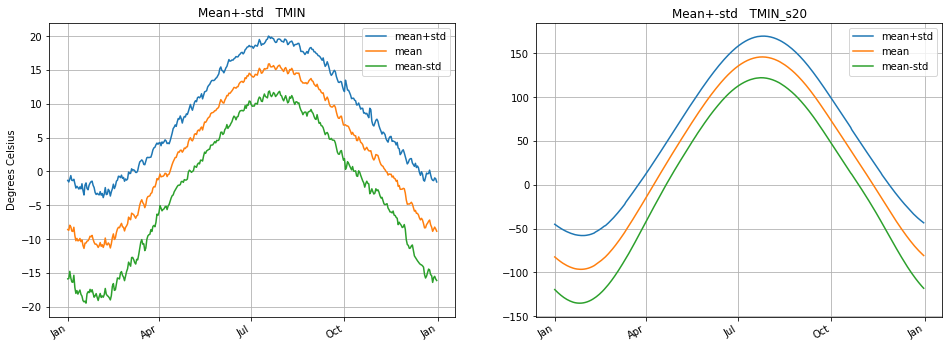

In [30]:
plot_pair(['TMIN','TMIN_s20'],plot_mean_std)

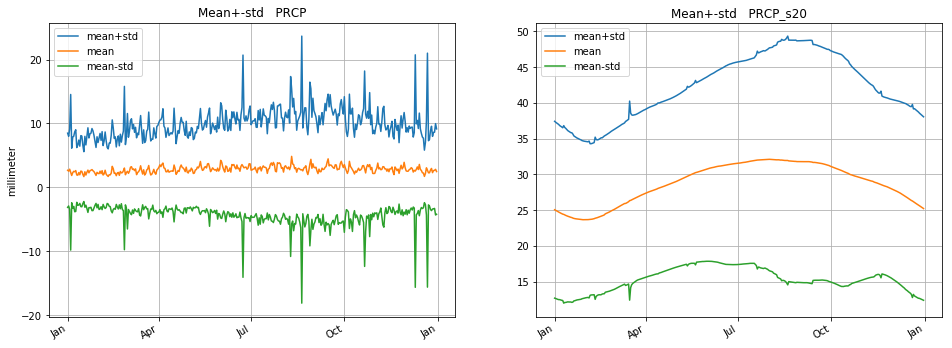

In [31]:
plot_pair(['PRCP','PRCP_s20'],plot_mean_std)

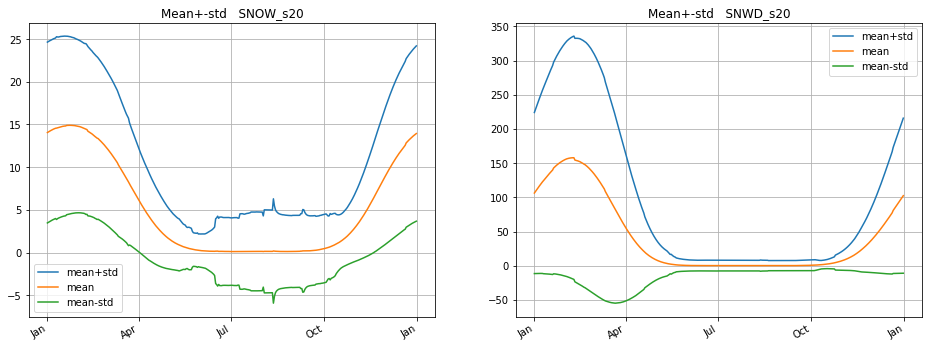

In [32]:
plot_pair(['SNOW_s20', 'SNWD_s20'],plot_mean_std)

### Plotting percentage of variance explained by Eigen-vectors

In [33]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    L=([0,]+list(cumsum(EV[:k])))/sum(EV)
    #print m,L
    plot(L)
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()

In [34]:
# create a subdirectory in which to place the plots.
!mkdir r_figures

mkdir: cannot create directory ‘r_figures’: File exists


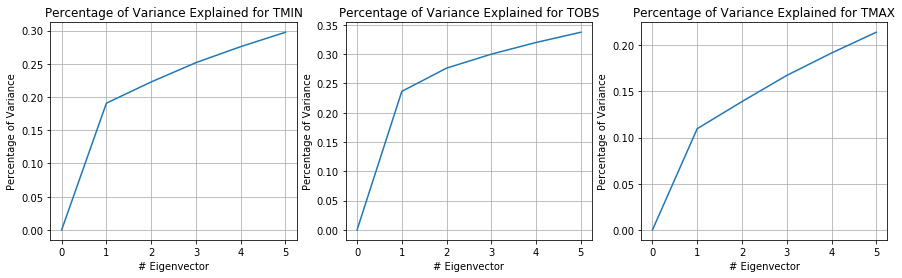

In [35]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1
f.savefig('r_figures/VarExplained1.png')

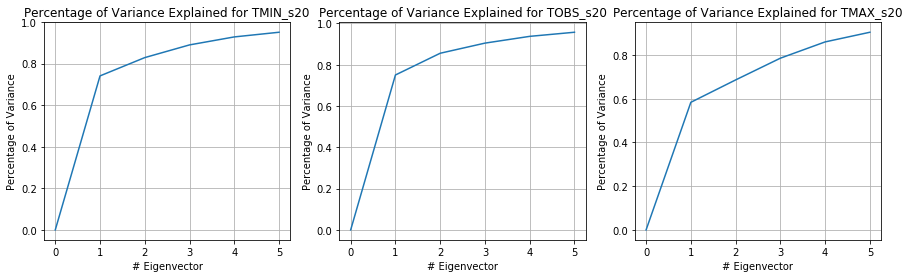

In [36]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN_s20', 'TOBS_s20', 'TMAX_s20']: #,
    pltVarExplained(j)
    j+=1
f.savefig('r_figures/VarExplained1.png')

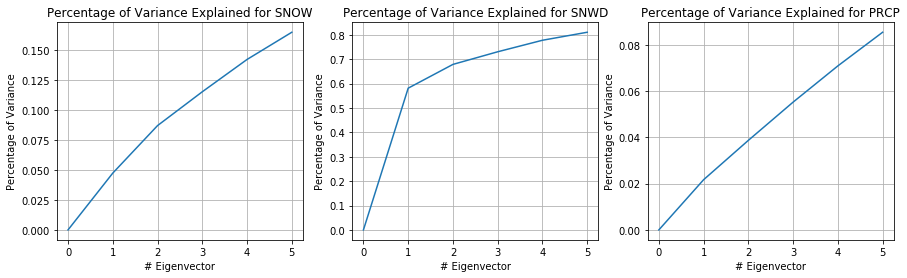

In [37]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 
f.savefig('r_figures/VarExplained2.png') 

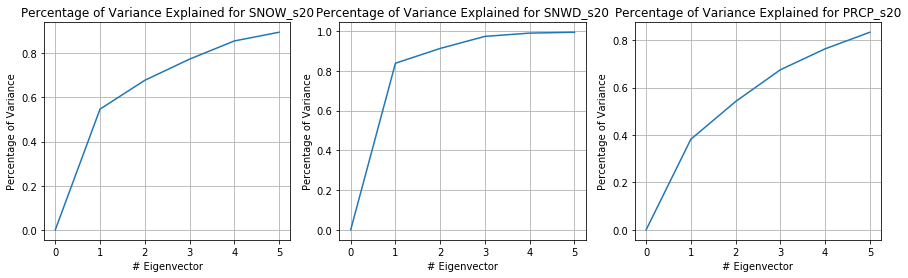

In [38]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW_s20', 'SNWD_s20', 'PRCP_s20']:
    pltVarExplained(j)
    j+=1 
f.savefig('r_figures/VarExplained2.png') 

### plotting top 3 eigenvectors

In [39]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

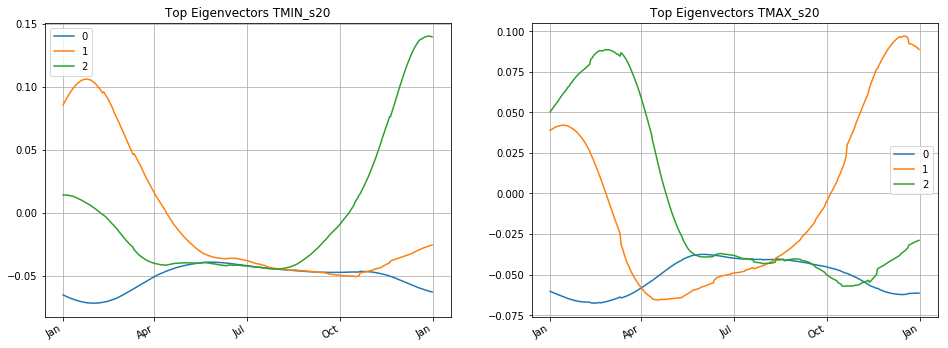

In [40]:
plot_pair(['TMIN_s20','TMAX_s20'],plot_eigen)

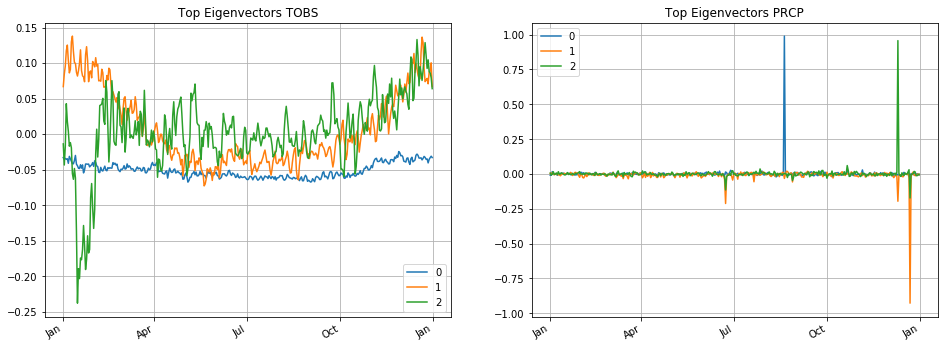

In [41]:
plot_pair(['TOBS','PRCP'],plot_eigen)

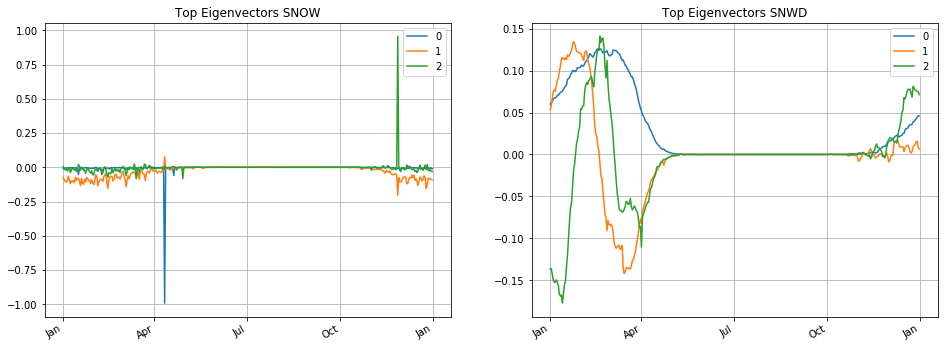

In [42]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

## Summary
We saw how to plot:
* Data from several (Station,Year,Measurement)
* The mean+-std for a particular (Station,Measurement)
* The percentage of cariance explained by top eigen-vectors.
* The top eigen-vectors